In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/moshida/EUVlitho


In [6]:
import numpy as np
from elitho import diffraction_amplitude, const, descriptors, diffraction_order, source

dod_narrow = descriptors.DiffractionOrderDescriptor(1.5)
dod_wide = descriptors.DiffractionOrderDescriptor(6.0)
doc_narrow = diffraction_order.DiffractionOrderCoordinate(
        dod_narrow.max_diffraction_order_x,
        dod_narrow.max_diffraction_order_y,
        diffraction_order.ellipse,
)
doc_wide = diffraction_order.DiffractionOrderCoordinate(
        dod_wide.max_diffraction_order_x,
        dod_wide.max_diffraction_order_y,
        diffraction_order.rounded_diamond,
)

In [7]:
from elitho.pupil import find_valid_pupil_points
linput, minput, xinput, n_input = find_valid_pupil_points(doc_wide.num_valid_diffraction_orders)
n_input, np.sum(xinput >= 8)

(105, np.int64(45))

In [8]:
dkx, dky, SDIV = source.uniform_k_source()

In [ ]:
import numpy as np

TCCXS0 = np.zeros((n_input, n_input), dtype=np.complex128)
TCCXSX = np.zeros((n_input, n_input), dtype=np.complex128)
TCCXSY = np.zeros((n_input, n_input), dtype=np.complex128)
TCCYS0 = np.zeros((n_input, n_input), dtype=np.complex128)
TCCYSX = np.zeros((n_input, n_input), dtype=np.complex128)
TCCYSY = np.zeros((n_input, n_input), dtype=np.complex128)

pmax = (const.k * const.NA) ** 2

for i in range(n_input):
    kx = 2 * np.pi / const.dx * linput[i]
    ky = 2 * np.pi / const.dy * minput[i]

    for j in range(i + 1):  # j <= i
        kxp = 2 * np.pi / const.dx * linput[j]
        kyp = 2 * np.pi / const.dy * minput[j]

        sumx_s0 = 0 + 0j
        sumy_s0 = 0 + 0j
        sumx_sx = 0 + 0j
        sumy_sx = 0 + 0j
        sumx_sy = 0 + 0j
        sumy_sy = 0 + 0j

        for is_ in range(SDIV):
            sx = dkx[is_]
            sy = dky[is_]

            ksx  = kx  + sx
            ksy  = ky  + sy
            ksxp = kxp + sx
            ksyp = kyp + sy

            if ((const.MX**2 * ksx**2 + const.MY**2 * ksy**2) <= pmax and
                (const.MX**2 * ksxp**2 + const.MY**2 * ksyp**2) <= pmax):

                phase  = np.exp(const.i_complex * ((ksx  + const.kx0)**2 + (ksy  + const.ky0)**2) / (2 * const.k) * const.z0)
                phasep = np.exp(const.i_complex * ((ksxp + const.kx0)**2 + (ksyp + const.ky0)**2) / (2 * const.k) * const.z0)

                denom_x = (const.k**2 - (const.kx0 + sx)**2)
                denom_y = (const.k**2 - (const.ky0 + sy)**2)

                sumx_s0 += phase * phasep.conjugate() / denom_x
                sumy_s0 += phase * phasep.conjugate() / denom_y
                sumx_sx += sx * phase * phasep.conjugate() / denom_x
                sumy_sx += sx * phase * phasep.conjugate() / denom_y
                sumx_sy += sy * phase * phasep.conjugate() / denom_x
                sumy_sy += sy * phase * phasep.conjugate() / denom_y

        TCCXS0[i, j] = sumx_s0 / SDIV
        TCCXS0[j, i] = TCCXS0[i, j].conjugate()
        TCCXSX[i, j] = sumx_sx / SDIV
        TCCXSX[j, i] = TCCXSX[i, j].conjugate()
        TCCXSY[i, j] = sumx_sy / SDIV
        TCCXSY[j, i] = TCCXSY[i, j].conjugate()
        TCCYS0[i, j] = sumy_s0 / SDIV
        TCCYS0[j, i] = TCCYS0[i, j].conjugate()
        TCCYSX[i, j] = sumy_sx / SDIV
        TCCYSX[j, i] = TCCYSX[i, j].conjugate()
        TCCYSY[i, j] = sumy_sy / SDIV
        TCCYSY[j, i] = TCCYSY[i, j].conjugate()

In [10]:
amp_absorber, amp_vacuum, phasexx = diffraction_amplitude.zero_order_amplitude("X", dod_wide, doc_narrow)

/home/moshida/EUVlitho/elitho/diffraction_amplitude.py:172: RuntimeWarning: invalid value encountered in scalar divide
  phasexx[x, y] = vcxx[x, y] / np.abs(vcxx[x, y])


In [11]:
from elitho.mask_pattern import LinePattern
from elitho import const
mask = LinePattern(cd=80, gap=60, direction="V", field_type="DF")(const.NDIVX, const.NDIVY)

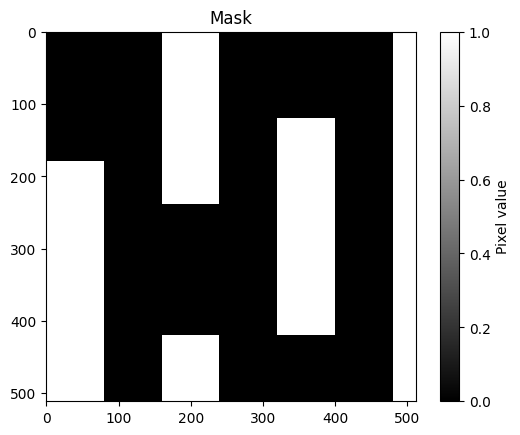

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()

In [13]:
hfpattern = mask * (amp_absorber - amp_vacuum) + amp_vacuum

In [14]:
# fft with scaling
fft_mask = np.fft.fft2(hfpattern, norm="forward")

In [15]:
fmask = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
# NOTE: NDIVX, NDIVYはもともとFDIVX, FDIVYという名前
for i in range(const.noutX):
    l = (i - const.lpmaxX + const.NDIVX) % const.NDIVX
    for j in range(const.noutY):
        m = (j - const.lpmaxY + const.NDIVY) % const.NDIVY
        fmask[i, j] = fft_mask[l, m]

In [16]:
fampxx = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
for ip in range(const.noutX):
    for jp in range(const.noutY):
        kxp = 2.0 * np.pi * (ip - const.lpmaxX) / const.dx
        kyp = 2.0 * np.pi * (jp - const.lpmaxY) / const.dy
        phasesp = np.exp(-const.i_complex * (const.kx0*kxp + kxp**2/2 + const.ky0*kyp + kyp**2/2) / (const.k * const.z0))
        fampxx[ip, jp] = fmask[ip, jp] * phasesp

In [17]:
fampxx /= phasexx

In [21]:
params = np.load("assets/params/m3d.npz")
d0, dx, dy = params["d0"], params["dx"], params["dy"]
a0xx = np.zeros((const.noutX, const.noutY), dtype=np.complex128)
axxx = np.zeros_like(a0xx)
ayxx = np.zeros_like(a0xx)
for n in range(n_input):
    ip = linput[n] + const.lpmaxX
    jp = minput[n] + const.lpmaxY
    a0xx[ip, jp] = d0[n]
    if xinput[n] >= 8:
        axxx[ip, jp] = dx[n]
        ayxx[ip, jp] = dy[n]

In [33]:
from enum import Enum
class SimulationMode(Enum):
    FAST = 1
    PRECISE = 2
    
# sim_mode = SimulationMode.FT
sim_mode = SimulationMode.PRECISE

In [31]:
import numpy as np

# 複素単位
zi = 1j
polar = "X"

# Pythonのリストを複素数配列で初期化
Exs0 = np.zeros(n_input, dtype=complex)
Eys0 = np.zeros(n_input, dtype=complex)
Ezs0 = np.zeros(n_input, dtype=complex)
Exsx = np.zeros(n_input, dtype=complex)
Eysx = np.zeros(n_input, dtype=complex)
Ezsx = np.zeros(n_input, dtype=complex)
Exsy = np.zeros(n_input, dtype=complex)
Eysy = np.zeros(n_input, dtype=complex)
Ezsy = np.zeros(n_input, dtype=complex)
Exsxy = np.zeros(n_input, dtype=complex)
Eysxy = np.zeros(n_input, dtype=complex)
Ezsxy = np.zeros(n_input, dtype=complex)

# intensity配列（空間分布用）
intensity = np.zeros((const.XDIV, const.XDIV))

# 各空間周波数成分ごとに電場成分を計算
for i in range(n_input):

    # --- 1) 波数ベクトル(kx, ky, kz) 計算 ---
    kxplus = const.kx0 + 2 * np.pi * linput[i] / const.dx / 2.0
    kyplus = const.ky0 + 2 * np.pi * minput[i] / const.dy / 2.0

    # kzはEvanescentを含むので負の平方根
    kzplus = -np.sqrt(const.k*const.k - kxplus*kxplus - kyplus*kyplus)

    # 周波数インデックス (wrap)
    ip = linput[i] + const.lpmaxX
    jp = minput[i] + const.lpmaxY
    lp = ip - const.lpmaxX
    mp = jp - const.lpmaxY

    # 電場スペクトル Ax or Ay (偏光成分)
    if polar == "X":  # X偏光
        if sim_mode == SimulationMode.FAST:
            Ax = fampxx[ip, jp]
            dxAx = 0.0
            dyAx = 0.0
        elif sim_mode == SimulationMode.PRECISE:
            Ax = fampxx[ip, jp] + a0xx[ip, jp]
            dxAx = axxx[ip, jp] * const.dx / (2 * np.pi)
            dyAx = ayxx[ip, jp] * const.dy / (2 * np.pi)

        # --- 2) ベクトル回折式のテイラー展開 ---
        Exs0[i] = zi*const.k*Ax - zi/const.k * kxplus*kxplus * Ax
        Exsx[i] = -2*zi/const.k*kxplus*Ax + zi*const.k*dxAx - zi/const.k*kxplus*kxplus*dxAx
        Exsy[i] = zi*const.k*dyAx - zi/const.k*kxplus*kxplus*dyAx
        Exsxy[i] = Exsx[i] / (const.dx/(2*np.pi)) * lp/2 + Exsy[i] / (const.dy/(2*np.pi)) * mp/2

        Eys0[i] = -zi/const.k * kxplus*kyplus * Ax
        Eysx[i] = -zi/const.k*kyplus*Ax - zi/const.k*kxplus*kyplus * dxAx
        Eysy[i] = -zi/const.k*kxplus*Ax - zi/const.k*kxplus*kyplus * dyAx
        Eysxy[i] = Eysx[i] / (const.dx/(2*np.pi)) * lp/2 + Eysy[i] / (const.dy/(2*np.pi)) * mp/2

        Ezs0[i] = -zi/const.k*kxplus*kzplus * Ax
        Ezsx[i] = -zi/const.k*kzplus*Ax - zi/const.k*kxplus*kzplus*dxAx
        Ezsy[i] = -zi/const.k*kxplus*kzplus * dyAx
        Ezsxy[i] = Ezsx[i] / (const.dx/(2*np.pi)) * lp/2 + Ezsy[i] / (const.dy/(2*np.pi)) * mp/2

    elif polar == "Y":  # Y偏光
        if type == 1:
            Ay = fampxx[ip, jp]
            dxAy = 0.0
            dyAy = 0.0
        else:
            Ay = fampxx[ip, jp] + a0xx[ip, jp]
            dxAy = axxx[ip, jp] * dx / (2*np.pi)
            dyAy = ayxx[ip, jp] * dy / (2*np.pi)

        Exs0[i] = -zi/const.k * kxplus*kyplus * Ay
        Exsx[i] = -zi/const.k*kyplus*Ay - zi/const.k*kxplus*kyplus * dxAy
        Exsy[i] = -zi/const.k*kxplus*Ay - zi/const.k*kxplus*kyplus * dyAy
        Exsxy[i] = Exsx[i] / (dx/(2*np.pi)) * lp/2 + Exsy[i] / (dy/(2*np.pi)) * mp/2

        Eys0[i] = zi/const.k*Ay - zi/const.k*kyplus*kyplus * Ay
        Eysx[i] = zi/const.k*dxAy - zi/const.k*kyplus*kyplus * dxAy
        Eysy[i] = -2*zi/const.k*kyplus*Ay + zi/const.k*dyAy - zi/const.k*kyplus*kyplus*dyAy
        Eysxy[i] = Eysx[i] / (dx/(2*np.pi)) * lp/2 + Eysy[i] / (dy/(2*np.pi)) * mp/2

        Ezs0[i] = -zi/const.k*kyplus*kzplus * Ay
        Ezsx[i] = -zi/const.k*kyplus*kzplus * dxAy
        Ezsy[i] = -zi/const.k*kzplus*Ay - zi/const.k*kyplus*kzplus * dyAy
        Ezsxy[i] = Ezsx[i] / (dx/(2*np.pi)) * lp/2 + Ezsy[i] / (dy/(2*np.pi)) * mp/2
    else:
        raise ValueError("polar must be 'X' or 'Y'")


In [36]:
import numpy as np

# TCCEE initialization
TCCEE = np.zeros((const.XDIV, const.XDIV), dtype=np.complex128)
if polar == "X":
    for i in range(n_input):
        ix = linput[i]
        iy = minput[i]
        for j in range(n_input):
            jx = linput[j]
            jy = minput[j]

            px = (ix - jx + const.XDIV) % const.XDIV
            py = (iy - jy + const.XDIV) % const.XDIV

            TCCEE[px, py] += (
                TCCXS0[i, j] *
                (Exs0[i] * np.conj(Exs0[j]) +
                 Eys0[i] * np.conj(Eys0[j]) +
                 Ezs0[i] * np.conj(Ezs0[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCXSX[i, j] *
                (Exs0[i] * np.conj(Exsx[j]) +
                 Eys0[i] * np.conj(Eysx[j]) +
                 Ezs0[i] * np.conj(Ezsx[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCXSY[i, j] *
                (Exs0[i] * np.conj(Exsy[j]) +
                 Eys0[i] * np.conj(Eysy[j]) +
                 Ezs0[i] * np.conj(Ezsy[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCXS0[i, j] *
                (Exs0[i] * np.conj(Exsxy[j]) +
                 Eys0[i] * np.conj(Eysxy[j]) +
                 Ezs0[i] * np.conj(Ezsxy[j]))
            )

elif polar == "Y":
    for i in range(n_input):
        ix = linput[i]
        iy = minput[i]
        for j in range(n_input):
            jx = linput[j]
            jy = minput[j]

            px = (ix - jx + const.XDIV) % const.XDIV
            py = (iy - jy + const.XDIV) % const.XDIV

            TCCEE[px, py] += (
                TCCYS0[i, j] *
                (Exs0[i] * np.conj(Exs0[j]) +
                 Eys0[i] * np.conj(Eys0[j]) +
                 Ezs0[i] * np.conj(Ezs0[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCYSX[i, j] *
                (Exs0[i] * np.conj(Exsx[j]) +
                 Eys0[i] * np.conj(Eysx[j]) +
                 Ezs0[i] * np.conj(Ezsx[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCYSY[i, j] *
                (Exs0[i] * np.conj(Exsy[j]) +
                 Eys0[i] * np.conj(Eysy[j]) +
                 Ezs0[i] * np.conj(Ezsy[j]))
            )

            TCCEE[px, py] += (
                2.0 * TCCYS0[i, j] *
                (Exs0[i] * np.conj(Exsxy[j]) +
                 Eys0[i] * np.conj(Eysxy[j]) +
                 Ezs0[i] * np.conj(Ezsxy[j]))
            )
    else:
        raise ValueError("polar must be 'X' or 'Y'")


In [37]:
ifft_tccee = np.fft.ifft2(TCCEE, norm="forward")

In [41]:
intensity = ifft_tccee.real

In [42]:
intensity

array([[0.18169897, 0.17572528, 0.17164446, ..., 0.21033339, 0.1990977 ,
        0.1895163 ],
       [0.19355294, 0.18861993, 0.18558914, ..., 0.2191717 , 0.20891964,
        0.20034457],
       [0.20513825, 0.2012275 , 0.19923067, ..., 0.22780777, 0.21851557,
        0.21092463],
       ...,
       [0.14741592, 0.13840084, 0.13126056, ..., 0.18490434, 0.17077485,
        0.15823852],
       [0.15835719, 0.15032447, 0.14417139, ..., 0.19298292, 0.17978931,
        0.16820844],
       [0.16987217, 0.162859  , 0.15773132, ..., 0.20152838, 0.18930558,
        0.17871575]], shape=(128, 128))

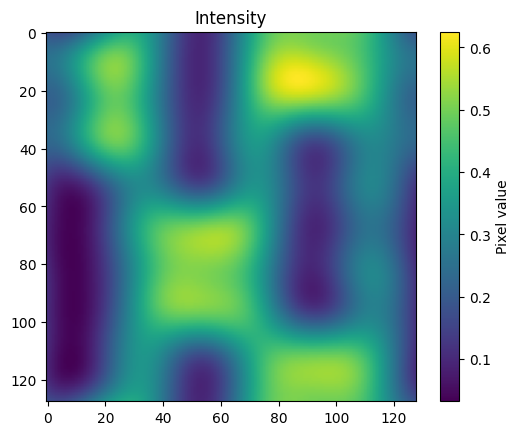

In [43]:
from matplotlib import pyplot as plt
plt.imshow(intensity)
plt.title("Intensity")
plt.colorbar(label="Pixel value")
plt.show()